# Trabajo Práctico 2: RandomForest

## Imports iniciales

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import tree
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import plot_tree
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from preprocesamiento import feature_engineering
from preprocesamiento import obtenerDFTraining
from preprocesamiento import preprocesar_data_frame

RANDOM_STATE = 19 * 103785

## Random Forests

Este modelo funciona similar a bagging, utilizar varios a modelos con diferentes sub-set del dataset de entrenamiendo. Pero con el agregado de que para evitar que mucho de estos modelos terminen pareciendoce mucho (debido a algunos features mas significativos que otros) se elije features de manera aleatoria.

Para este modelo se buscaran los siguientes hiperparametros:

+ criterion --> El criterio para medir el gain de generar una nueva particion de un nodo.
+ max_depth --> Maxima profundidad del arbol.
+ min_samples_split --> El número mínimo de muestras necesarias para dividir un nodo.
+ max_features --> La cantidad de características a considerar al buscar la mejor división.
+ class_weight --> Importancia de alto y bajo poder adquisitivo.

In [2]:
from preprocesamiento import metricas
from preprocesamiento import prepros_dummies
from preprocesamiento import preprocesar_df_min_max_scaler

Inicialmente seleccionaremos las variables mas relevantes para las categoricas hacemos un one hot encoding y las numericas las escalaremos con MinMaxScaler.

In [3]:
df = obtenerDFTraining()
(X, y) = preprocesar_data_frame(df)
X = prepros_dummies(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                       'estado_marital','genero',"edad","anios_estudiados"]])
X_prepros = preprocesar_df_min_max_scaler(X)
x_train, x_test, y_train, y_test = train_test_split(X_prepros, y, test_size=0.25, random_state=RANDOM_STATE)

In [6]:
parametros = {'n_estimators': [100,500,1000,2500,5000,10000], 'criterion' : ['gini','entropy'], 'max_depth':range(8,11), 
              "min_samples_split" : [10,100,500,1000],
              'class_weight' :  [{0: 1,1: 1},{0: 1,1: 1.25},{0: 1,1: 1.5},{0: 1,1: 2}],
              'random_state':[RANDOM_STATE]} 

random_forest = RandomForestClassifier()
clf = GridSearchCV(random_forest, parametros, n_jobs = -1, verbose = 4, scoring = "roc_auc")

clf.fit(x_train, y_train)
print(classification_report(y_test,clf.predict(x_test)))
clf.best_params_

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 20.7min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 44.7min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 78.7min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 146.3min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 237.1min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 296.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 365.6min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed: 444.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 529.8min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 614.1min finished


              precision    recall  f1-score   support

           0       0.88      0.93      0.91      6196
           1       0.73      0.61      0.66      1936

    accuracy                           0.85      8132
   macro avg       0.81      0.77      0.79      8132
weighted avg       0.85      0.85      0.85      8132



{'class_weight': {0: 1, 1: 1.25},
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_split': 10,
 'n_estimators': 500,
 'random_state': 1971915}

Una vez realizada la busqueda, entrenamos individualmente el mejor modelo y vemos sus metricas.

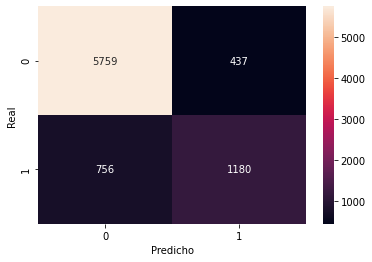

Recall: 0.61
Precision: 0.73
Acc: 0.85
Roc: 0.91


In [7]:
df = obtenerDFTraining()
(X, y) = preprocesar_data_frame(df)
X = prepros_dummies(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                       'estado_marital','genero',"edad","anios_estudiados"]])
X_prepros = preprocesar_df_min_max_scaler(X)
x_train, x_test, y_train, y_test = train_test_split(X_prepros, y, test_size=0.25, random_state=RANDOM_STATE)


random_forest_dummies = RandomForestClassifier( class_weight = {0: 1, 1: 1.25}, criterion = 'gini', max_depth = 10,
                                min_samples_split = 10,n_estimators = 500,
                                random_state = RANDOM_STATE)

random_forest_dummies.fit(x_train, y_train)

metricas(y_test,random_forest_dummies.predict(x_test),x_test,random_forest_dummies)

## Otro preprocesamiento: PCA

In [8]:
from preprocesamiento import preprocesar_df_pca

df = obtenerDFTraining()
X, y = preprocesar_data_frame(df)
X = preprocesar_df_min_max_scaler(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados"]])
X = preprocesar_df_pca(X,18)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)

In [10]:
parametros = {'n_estimators': [100,500,1000,5000,10000], 'criterion' : ['gini','entropy'], 'max_depth':range(8,11), 
              "min_samples_split" : [100,500,1000],
              'class_weight' :  [{0: 1,1: 1},{0: 1,1: 1.25},{0: 1,1: 1.5},{0: 1,1: 2}],
              'random_state':[RANDOM_STATE]} 

random_forest = RandomForestClassifier()
clf = GridSearchCV(random_forest, parametros, n_jobs = -1, verbose = 4,scoring = 'roc_auc')

clf.fit(x_train, y_train)
print(classification_report(y_test,clf.predict(x_test)))
clf.best_params_

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed: 94.0min
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed: 169.5min
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed: 263.2min
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed: 385.0min
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed: 513.1min
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed: 690.1min
[Parallel(n_jobs=-1)]: Done 1800 out of 1800 | elapsed: 844.8min finished


              precision    recall  f1-score   support

           0       0.87      0.92      0.89      6196
           1       0.69      0.54      0.61      1936

    accuracy                           0.83      8132
   macro avg       0.78      0.73      0.75      8132
weighted avg       0.82      0.83      0.83      8132



{'class_weight': {0: 1, 1: 1},
 'criterion': 'gini',
 'max_depth': 10,
 'min_samples_split': 100,
 'n_estimators': 5000,
 'random_state': 1971915}

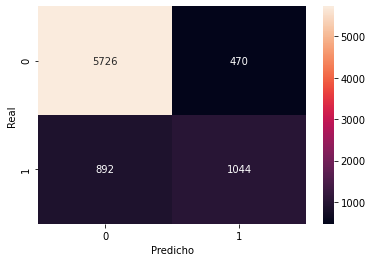

Recall: 0.54
Precision: 0.69
Acc: 0.83
Roc: 0.88


In [12]:
df = obtenerDFTraining()
X, y = preprocesar_data_frame(df)
X = preprocesar_df_min_max_scaler(X[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                                      'estado_marital','genero',"anios_estudiados"]])
X = preprocesar_df_pca(X,18)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)


clf_rf = RandomForestClassifier( class_weight = {0: 1, 1: 1}, criterion = 'gini', max_depth = 10,
                                max_features = 'auto',min_samples_split = 100,n_estimators = 5000,
                                random_state = RANDOM_STATE)

clf_rf.fit(x_train, y_train)

metricas(y_test,clf_rf.predict(x_test),x_test,clf_rf)

Es interesante destacar que para ambos preprocesamiento, se encontro la misma configuraciones pero se puede notar una diferencia significativa en las metricas para ambos.

### Prediccion sobre el Holdout

In [13]:
from preprocesamiento import obtenerDFHoldout
from preprocesamiento import escribir_predicciones_a_archivo

holdout = obtenerDFHoldout()

ids = np.array(holdout['id'])
holdout = prepros_dummies(holdout[['ganancia_perdida_declarada_bolsa_argentina','trabajo',
                       'estado_marital','genero',"edad","anios_estudiados"]])
holdout = preprocesar_df_min_max_scaler(holdout)

predicciones_holdout = random_forest_dummies.predict(holdout)
escribir_predicciones_a_archivo(predicciones_holdout,"Random Forest",ids)